In [1]:
!nvidia-smi

Tue May 19 15:49:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
!pip install mpu

In [3]:
!pip install tensorflow-gpu >> /dev/null

In [4]:
!pip install --upgrade grpcio >> /dev/null

In [5]:
!pip install tqdm  >> /dev/null

In [6]:
!pip install bert-for-tf2 >> /dev/null

In [7]:
!pip install sentencepiece >> /dev/null

In [8]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

--2020-05-19 15:50:15--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2020-05-19 15:50:16--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.34’

thsarabunnew-webfon 100%[===================>]  96.00K   179KB/s    in 0.5s    

2020-05-19 15:50:17 (179 KB/s) - ‘

In [9]:
import matplotlib
import matplotlib.font_manager as fm
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')

In [10]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,0"

In [11]:
!export CUDA_VISIBLE_DEVICES="1,0"

In [12]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [13]:
## Load data
train = pd.read_csv("train1.csv")
valid = pd.read_csv("dev1.csv")
test = pd.read_csv("test1.csv")

In [14]:
train = train.append(valid).reset_index(drop=True)

In [15]:
train.shape

(981587, 2)

In [16]:
train.head()

,text,intent
0,ขยายประเด็นร้อนระวังแท็กซี่หื่นภัยร้ายใกล้ตัวคน,การบิน
1,เรื่องเล่าจากคันไซเรื่องเล่าจากคันไซตอนที่1,ภัยพิบัติ
2,ข่าวสั้นกรมธนารักษ์จัดงานนิทรรศการยิ่งใหญ่,อสังหา
3,รุ้งตัดแวงก่อการร้ายซิ่งชน,สงคราม
4,ทางเสือผ่านอย่าเพิ่งทำอะไรเสี่ยงๆได้ไหมหมอเลี้ยบ,ธนาคาร


/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3609 missing 

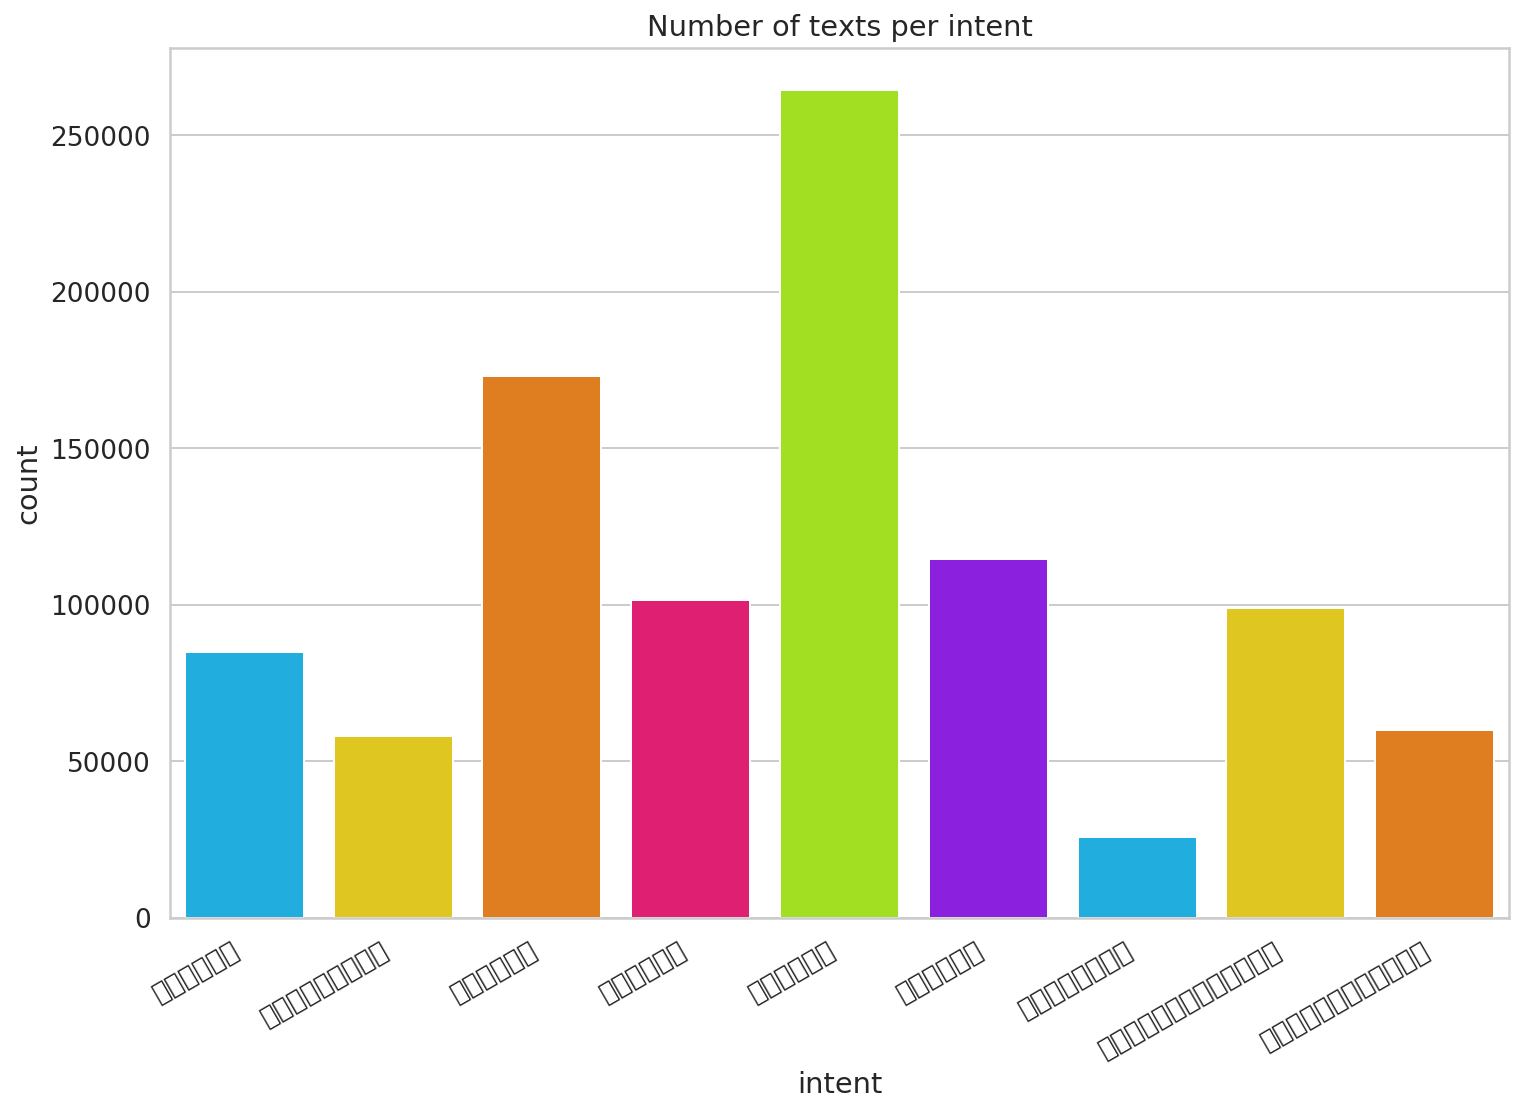

In [17]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [18]:
## Pre-train BERT เปลี่ยน path

In [19]:
cd/Bert_datasets

[Errno 2] No such file or directory: '/Bert_datasets'
/data/Full_datasets


In [20]:
ls -al

total 797983
drwxr-xr-x  6 root root        61 May 19 15:50 ./
drwxr-xr-x 10 root root        11 May 19 03:59 ../
-rw-r--r--  1 root root     39029 May 17 11:53 Bert-ChungZa777.ipynb
-rw-r--r--  1 root root    165436 May 19 15:47 Bert-ChungZa888.ipynb
-rwxr-xr-x  1 root root    103631 May 13 07:14 Bert_edited.ipynb*
-rw-r--r--  1 root root      8117 May 13 07:24 Bert_edited.py
-rw-r--r--  1 root root    166700 May 17 11:53 Bert.ipynb
-rw-r--r--  1 root root      9224 May 13 06:58 Bert.py
-rw-r--r--  1 root root 415266491 May 17 11:23 ChungZaa777.pickle
-rw-r--r--  1 root root 443140925 May 17 11:21 data.npy
-rwxr-xr-x  1 root root   1471478 May 12 17:19 dev1.csv*
-rw-r--r--  1 root root      6148 May 12 17:18 .DS_Store
-rw-r--r--  1 root root 415266491 May 17 11:22 filename.pickle
-rwxr-xr-x  1 root root 146011227 May 12 17:19 full_datasets.csv*
-rw-r--r--  1 root root 415266491 May 19 04:01 Intent_clf.pickle
drwxr-xr-x  2 root root         9 May 19 03:56 .ipynb_checkpoints/
drwxr-xr-x

In [21]:
#!unzip multi_cased_L-12_H-768_A-12.zip

In [22]:
os.makedirs("model", exist_ok=True)

In [23]:
#!mv multi_cased_L-12_H-768_A-12/ model

In [24]:
bert_model_name="multi_cased_L-12_H-768_A-12" #เปลี่ยน path

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [25]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [26]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [27]:
tokenizer.tokenize("ฉันไปโรงเรียน")

['ฉ', '##น', '##ไ', '##ป', '##โ', '##ร', '##ง', '##เ', '##ร', '##ยน']

In [28]:
tokens = tokenizer.tokenize("ฉันไปโรงเรียน")
tokenizer.convert_tokens_to_ids(tokens)

[1401, 16000, 111435, 49292, 111433, 22765, 19197, 111431, 22765, 67390]

In [29]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [30]:
classes = train.intent.unique().tolist()

#data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

In [31]:
import mpu 
data = mpu.io.read('Intent_clf.pickle')

In [32]:
# !pip install mpu
# import mpu as chungza888
# data = chungza888.io.read('ChungZaa777.pickle')

In [33]:
data

In [34]:
data.train_x.shape

(981587, 51)

In [35]:
data.train_x[0]

array([   101,   1396,  54633,  20503,  49292,  22765,  22598, 111431,
        22123,  16000,  22765,  45629,  22765,  22598,  80182, 111432,
        37022,  18427,  91692, 111424,  16000, 111422,  20503,  22765,
        39376, 111434,  18427,  20507,  30011,  31287,  31256,  16000,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0])

In [36]:
data.train_y[0]

0

In [37]:
data.max_seq_len

51

In [38]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 51, 768)
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fb34739bdd0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 51)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 51, 768)           177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 6921  

In [40]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5), #ปรับ
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [41]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.3,
  batch_size=128, #ปรับ
  shuffle=True, 
  epochs=5,      #ปรับ
  callbacks=[tensorboard_callback]
)

Train on 687110 samples, validate on 294477 samples
Epoch 1/5
401024/687110 [================>.............] - ETA: 58:15 - loss: 1.8227 - acc: 0.5454

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



687110/687110 [==============================] - 9548s 14ms/sample - loss: 1.7592 - acc: 0.6097 - val_loss: 1.6403 - val_acc: 0.7300
Epoch 2/5
687110/687110 [==============================] - 9457s 14ms/sample - loss: 1.6304 - acc: 0.7399 - val_loss: 1.6118 - val_acc: 0.7591
Epoch 3/5
687110/687110 [==============================] - 9491s 14ms/sample - loss: 1.6070 - acc: 0.7637 - val_loss: 1.5945 - val_acc: 0.7760
Epoch 4/5
687110/687110 [==============================] - 9514s 14ms/sample - loss: 1.5942 - acc: 0.7764 - val_loss: 1.5851 - val_acc: 0.7859
Epoch 5/5
687110/687110 [==============================] - 9523s 14ms/sample - loss: 1.5858 - acc: 0.7851 - val_loss: 1.5813 - val_acc: 0.7898


## Evaluation

In [42]:
%load_ext tensorboard

In [43]:
%tensorboard --logdir log

Reusing TensorBoard on port 6006 (pid 10208), started 1 day, 5:49:48 ago. (Use '!kill 10208' to kill it.)

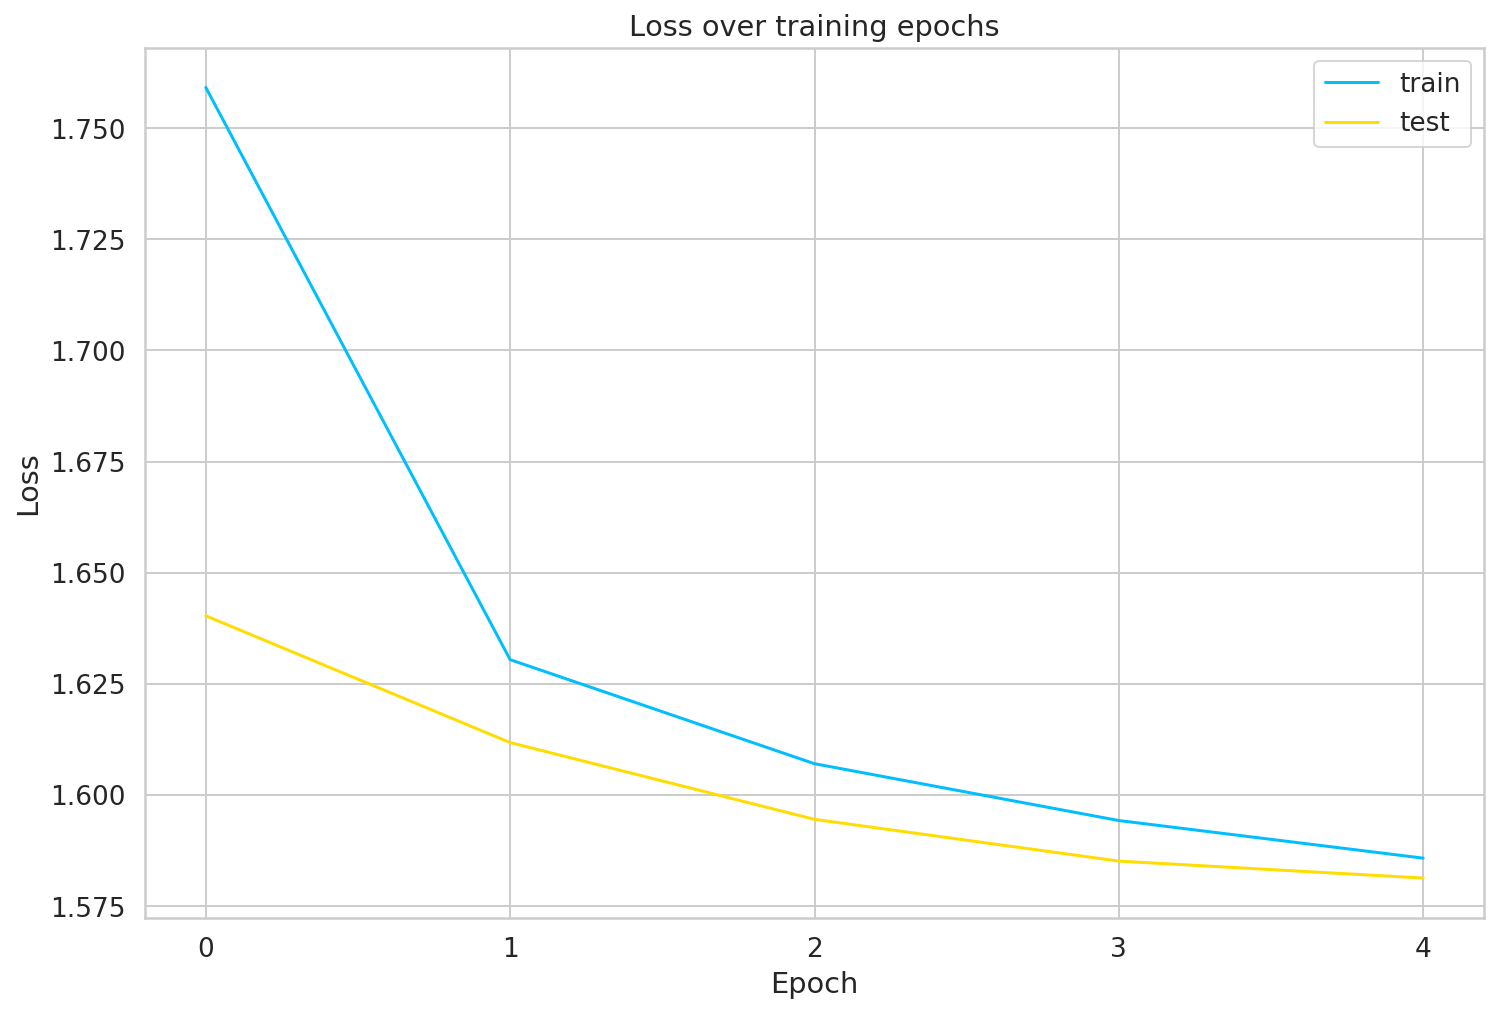

In [44]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

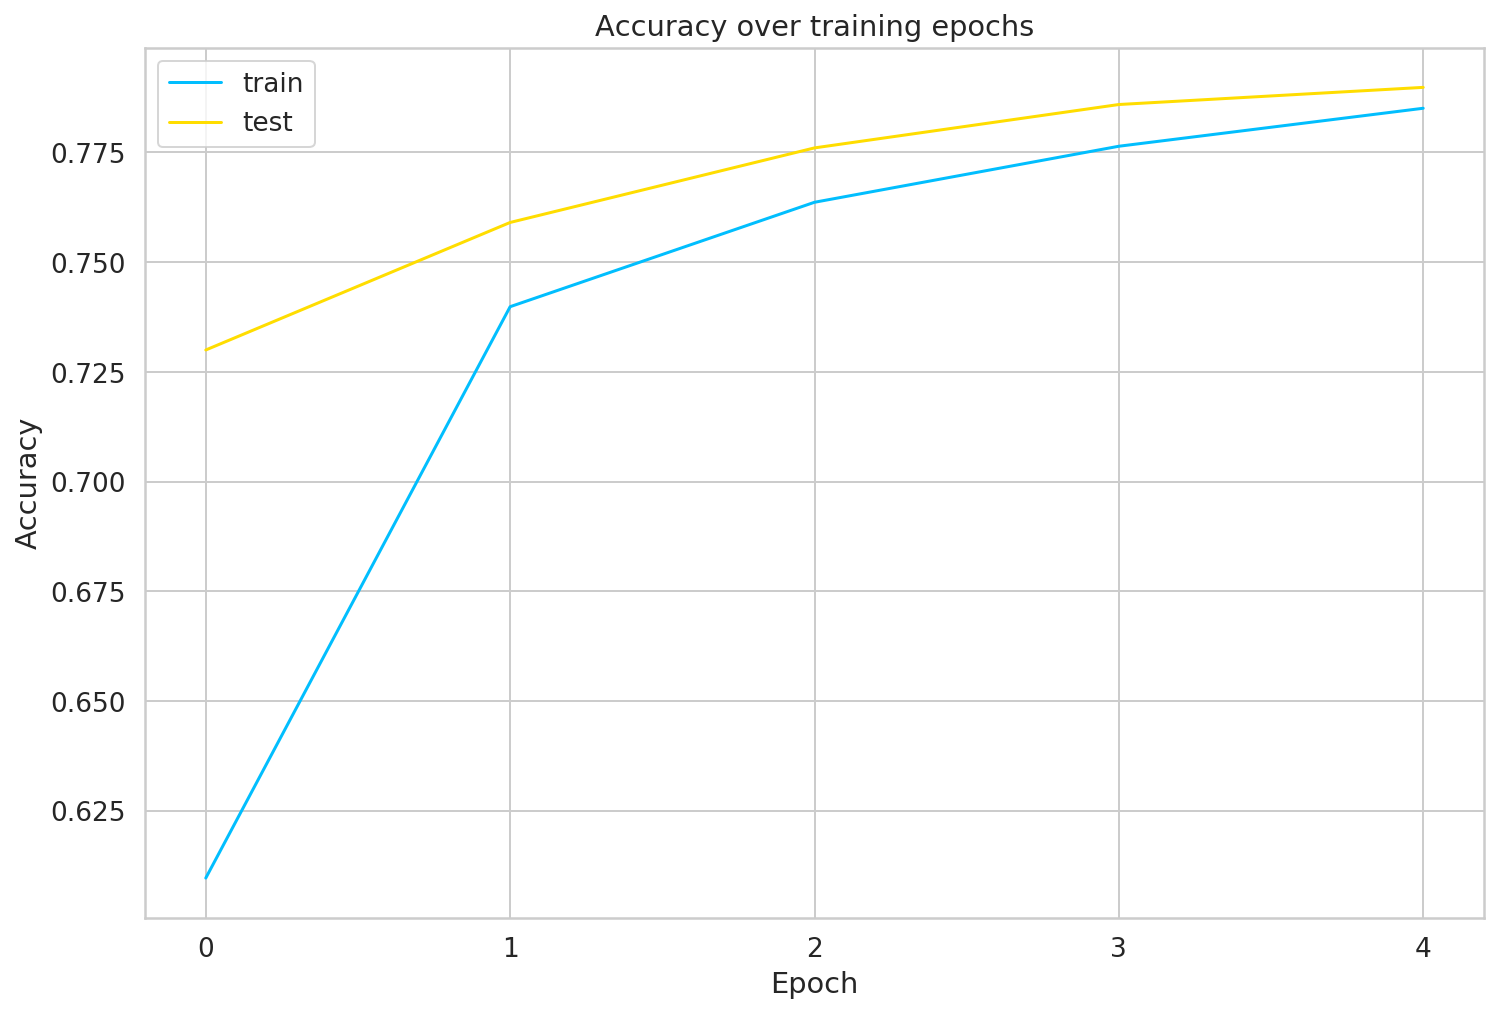

In [45]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [46]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

train acc 0.7961444
test acc 0.7915


In [47]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [48]:
print(classification_report(data.test_y, y_pred, target_names=classes))

               precision    recall  f1-score   support

       การบิน       0.79      0.76      0.78       825
    ภัยพิบัติ       0.75      0.83      0.79       573
       อสังหา       0.84      0.76      0.80      1732
       สงคราม       0.79      0.89      0.83      1036
       ธนาคาร       0.80      0.86      0.83      2756
       น้ำมัน       0.83      0.75      0.79      1193
     โรคระบาด       0.84      0.84      0.84       225
ธุรกิจค้าปลีก       0.68      0.74      0.71      1033
 พลังงานไฟฟ้า       0.83      0.56      0.67       627

     accuracy                           0.79     10000
    macro avg       0.79      0.78      0.78     10000
 weighted avg       0.79      0.79      0.79     10000



In [49]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3609 missing 

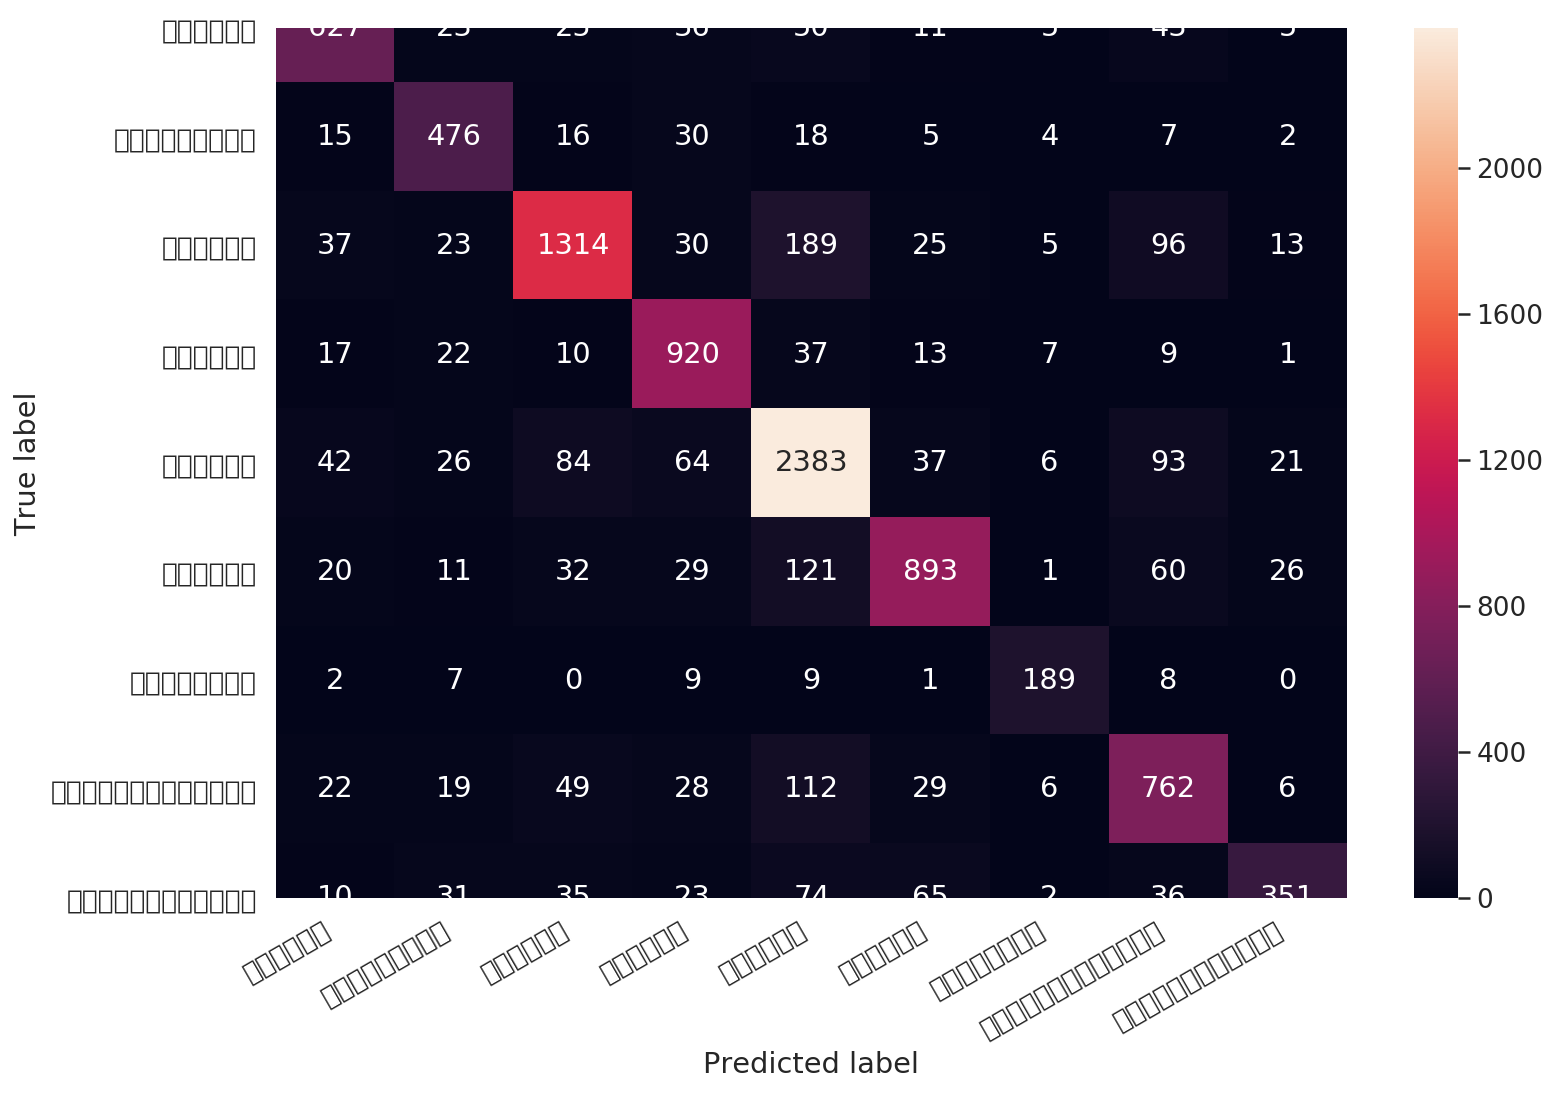

In [50]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [51]:
sentences = [
  "กสิกรฯขึ้นดอกเบี้ยฝาก025แบงก์อื่นลังเลรอดูผลกระทบ",
  "ปตทเชื่อรายได้ทะลุ1ล้านล้านรับราคาน้ำมันสูงต่อเนื่องทั้งปี"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: กสิกรฯขึ้นดอกเบี้ยฝาก025แบงก์อื่นลังเลรอดูผลกระทบ 
intent: ธนาคาร

text: ปตทเชื่อรายได้ทะลุ1ล้านล้านรับราคาน้ำมันสูงต่อเนื่องทั้งปี 
intent: น้ำมัน

